/home/josebraz/anaconda3/envs/geo_env/lib/python3.9/site-packages/pysal/lib/cg/alpha_shapes.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/home/josebraz/anaconda3/envs/geo_env/lib/python3.9/site-packages/pysal/lib/cg/alpha_shapes.py:155: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/home/josebraz/anaconda3/envs

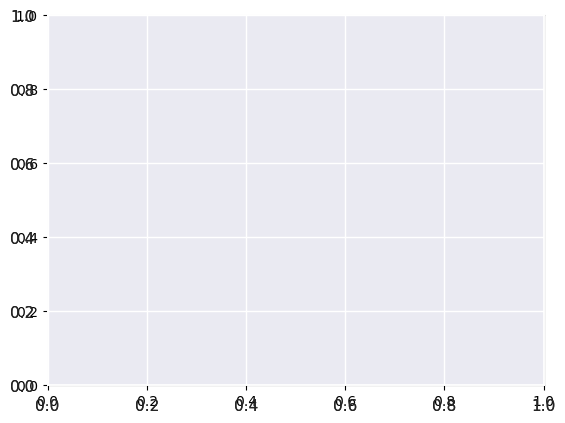

In [1]:
import numpy as np
import geopandas as gpd
import shapely

from explore import *
from utils import *
from graphic import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

import warnings
warnings.filterwarnings('ignore')

# dados de https://appeears.earthdatacloud.nasa.gov

In [2]:
df = read_burn_df()
df.drop(["pais", "estado", "municipio", "bioma", "diasemchuva", "precipitacao", "riscofogo", "frp"], axis=1, inplace=True)
df = df[(df["simp_satelite"] != "ATSR") & (df["simp_satelite"] != "TRMM")]

In [3]:
# parametros escolhidos para a aplicação do AQ-FA
quadrat_width = 0.005
burned_area_calc = polinomial_burned_area_calc(5, 10, 3)
min_area_percentage=0.1
threshold_satellite=2

In [4]:

def read_file_normalized_cached(path, row, file, quadrat_width) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    gdf_normal = gpd.read_file(file)
    region = get_landsat_geometry(path, row)
    norm_name = os.path.join(cache_folder, 'norm', f"{quadrat_width}_{os.path.basename(os.path.splitext(file)[0])}")
    if os.path.exists(norm_name):
        gdf_normalized = gpd.read_file(norm_name)
    else:
        gdf_normalized = normalize_gdf(gdf_normal, region, quadrat_width)
        gdf_normalized.to_file(norm_name)
    return (gdf_normal, gdf_normalized)

In [5]:
hour = "14:00:00-03:00"

from datetime import datetime

def get_infos_from_aq30m(file: str) -> tuple[int, int, str, str]:
    path, row, end_date = os.path.basename(file).split('_')[2:5]
    path, row, end_date = int(path), int(row), datetime.strptime(end_date, '%Y%m%d')
    start = (end_date - timedelta(days=16)).strftime('%Y-%m-%d') + f' {hour}'
    end = end_date.strftime('%Y-%m-%d') + f' {hour}'
    return path, row, start, end
    

In [ ]:
from utils import _grid_gdf_cached
_grid_gdf_cached.cache_info()

In [8]:
import time
import glob
from multiprocessing import Pool

dt = pd.DataFrame({ 'aqm30_file': glob.glob("aq30m/*.zip") })

# ranges: 
# grande (2.5 - 15)
# inferior (2, 6.5)
# superior (7.5 - 15)

def validate(args) -> dict:
    aq30m_file, quadrat_width = args
    aq30m_file, quadrat_width = str(aq30m_file), float(quadrat_width)
    path, row, start, end = get_infos_from_aq30m(aq30m_file)
    burned_area_calc = linear_burned_area_calc(2.5, 15)

    # file_name = os.path.join(cache_folder, 'aq-fa', '''AQ-FA_{path}_{row}_{start.split(' ')[0]}_{end.split(' ')[0]}''')
    
    region = get_landsat_geometry(path, row)
    aqm_gdf, aqm_normalized_gdf = read_file_normalized_cached(path, row, aq30m_file, quadrat_width)

    explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
    explorer = SatellitesExplore(explore_df, 
                                    delimited_region=region,
                                    quadrat_width=quadrat_width, 
                                    burned_area_calc=burned_area_calc,
                                    min_area_percentage=min_area_percentage,
                                    threshold_satellite=threshold_satellite)
    burned = explorer.get_burned_areas()

    model_area_km2 = burned['burned_are'].sum() / 1000000
    temp = gpd.GeoDataFrame({ 'value': burned['burned_fac'], 'geometry': burned['geometry'] }, crs=burned.crs)
    d = evaluate_gpd(aqm_normalized_gdf, temp)
    d['start_dt'] = start
    d['end_dt'] = end
    d['reference_area_km2'] = aqm_gdf['km2'].sum()
    d['model_area_km2'] = model_area_km2
    d['orbita_ponto'] = f"{path:03d}/{row:03d}"
    return d

items = [np.append(*dt.iloc[i].values, quadrat_width) for i in range(len(dt))]

with Pool(4) as pool:
    values = pool.map(validate, items, chunksize=1)
    dt = pd.concat([dt, pd.DataFrame(values)], axis=1)
    dt.to_csv(f'results/validate_results_linear_2-5_15_{int(time.time())}.csv')
dt

columns = ['orbita_ponto', 'start_dt', 'end_dt', 'ACC', 'CSI', 'CE', 'OE', 'B', 'DC', 'reference_area_km2', 'model_area_km2']
print('\n'.join(to_pretty_table_latex(dt, columns, ["DC"]).values))


HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
HIT
\multirow{2}{*}{221/070} & 25/08/2017 & 98.34\% & 35.39\% & 1.24 & $697.9Km^2$ \\
                         & 10/09/2017 & 0.56 & 19.96\% & 71.49\% & $864.5Km^2$ \\
\hline
\multirow{2}{*}{221/070} & 31/08/2019 & 97.86\% & 35.62\% & 1.22 & $882.2Km^2$ \\
                         & 16/09/2019 & 0.55 & 21.73\% & 70.64\% & $1070.7Km^2$ \\
\hline
\multirow{2}{*}{224/069} & 25/08/2021 & 97.40\% & 28.62\% & 0.95 & $1181.5Km^2$ \\
                         & 10/09/2021 & 0.53 & 32.08\% & 69.60\% & $1124.8Km^2$ \\
\hline
\multirow{2}{*}{221/067} & 31/08/2019 & 97.44\% & 31.70\% & 0.84 & $1006.1Km^2$ \\
                         & 16/09/2019 & 0.45 & 42.81\% & 62.24\% & $842.4Km^2$ \\
\hline
\multirow{2}{*}{220/074} & 11/09/2020 & 96.73\% & 56.02\% & 1.79 & $699.0Km^2$ \\
                         & 27/09/2020 & 0.39 & 21.37\% & 56.40\% & $1247.3Km^2$ \\
\hline
\multirow{2}{*}{221/067} & 04/08/2021 & 98.68\% 

In [ ]:
aq30m_file = 'aq30m/LS8_AQM_220_074_20200927_0114.zip'
path, row, start, end = get_infos_from_aq30m(aq30m_file)
aqm_gdf, aqm_normalized_gdf = read_file_normalized_cached(path, row, aq30m_file, quadrat_width)


In [ ]:
wrs2: gpd.GeoDataFrame = gpd.read_file('aux/grade_tm_am_do_sul')
estados_shape: gpd.GeoDataFrame = gpd.read_file(uf_folder + '/BR_UF_2021.shp')

join = gpd.sjoin(estados_shape, wrs2)
brasil_wrs2 = wrs2.iloc[join['index_right'].unique()]

In [ ]:
from multiprocessing import Pool

argss = [[brasil_wrs2.loc[index]['ORBITA'], brasil_wrs2.loc[index]['PONTO'], 
          f'{start} 00:00:00-03:00', f'{end} 23:59:59-03:00', year] 
          for year in [2021, 2022, 2018, 2017]
          for (start, end) in get_year_date_pairs(year)
          for index in brasil_wrs2.T]

def calculate(args) -> float:
    path, row, start, end, year = args
    path, row = int(path), int(row)
    file_name = f'''aq_fa_{year}/AQ-FA_{path}_{row}_{start.split(' ')[0]}_{end.split(' ')[0]}'''
    if os.path.exists(file_name): return 0.0
    # print(f"Computing {file_name}...")
    try:
        explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
        if len(explore_df) == 0:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
            return 0.0
        region = get_landsat_geometry(path, row)
        explorer = SatellitesExplore(explore_df, 
                                     delimited_region=region,
                                     quadrat_width=quadrat_width, 
                                     burned_area_calc=burned_area_calc,
                                     min_area_percentage=min_area_percentage,
                                     threshold_satellite=threshold_satellite)
        burned = explorer.get_burned_areas()
        temp = burned[burned['value'] > 0]
        if len(temp) > 0:
            temp.to_file(file_name)
        else:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
        km2 = explorer.get_total_area_m_2() / 1000000
        del explore_df, explorer, region, burned
        return km2
    except KeyboardInterrupt as error:
        raise error
    except Exception as error:
        print(f"ERROR {path}/{row}", error)
        raise error

print("Computing", len(argss), "values...")
with Pool(4) as pool:
    pool.map(calculate, argss, chunksize=1)

In [ ]:
import glob

year = 2019
aq1km = pd.read_csv('aq1km/area_queimada_aq1km.csv')
date_pairs = get_year_date_pairs(year)

def compare(args):
    start, end = args
    month = int(start.split('-')[1]) 
    files = glob.iglob(f'aq_fa_{year}/AQ-FA_*_*_{start}_{end}')
    new_calc = BurnedAreaCalcPercentile(expoent=2)
    gdfs_raw = (gpd.read_file(file) for file in files if len(os.listdir(file)) > 0)
    gdfs_area = (SatellitesExplore.recalcule_burned_area_static(new_calc, gdf).sum() for gdf in gdfs_raw)
    burned_aq1km = aq1km[(aq1km['Ano'] == year) & (aq1km['Mês'] == month)].iloc[0]['Total mensal']
    burned_aqfa = np.sum(gdfs_area)
    return { 
        'Ano': year, 
        'Mês': month, 
        'AQ-FA': round(burned_aqfa), 
        'AQ1km': round(burned_aq1km)
    }

values = []
with Pool(5) as pool:
    values = pool.map(compare, date_pairs)

data_df = pd.DataFrame(values)
data_df

<Axes: xlabel='Mês'>

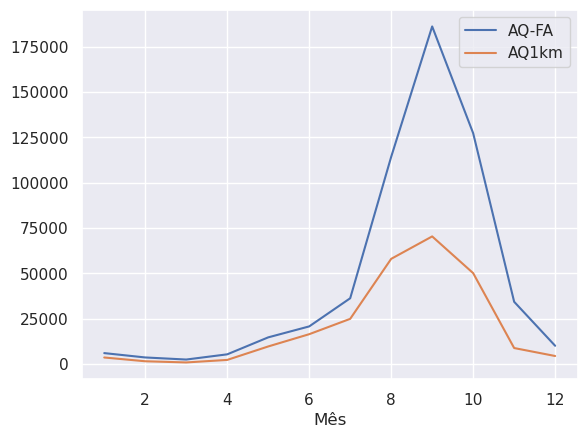

In [56]:
data_df.drop(["Ano"], axis=1).set_index(["Mês"]).plot.line()

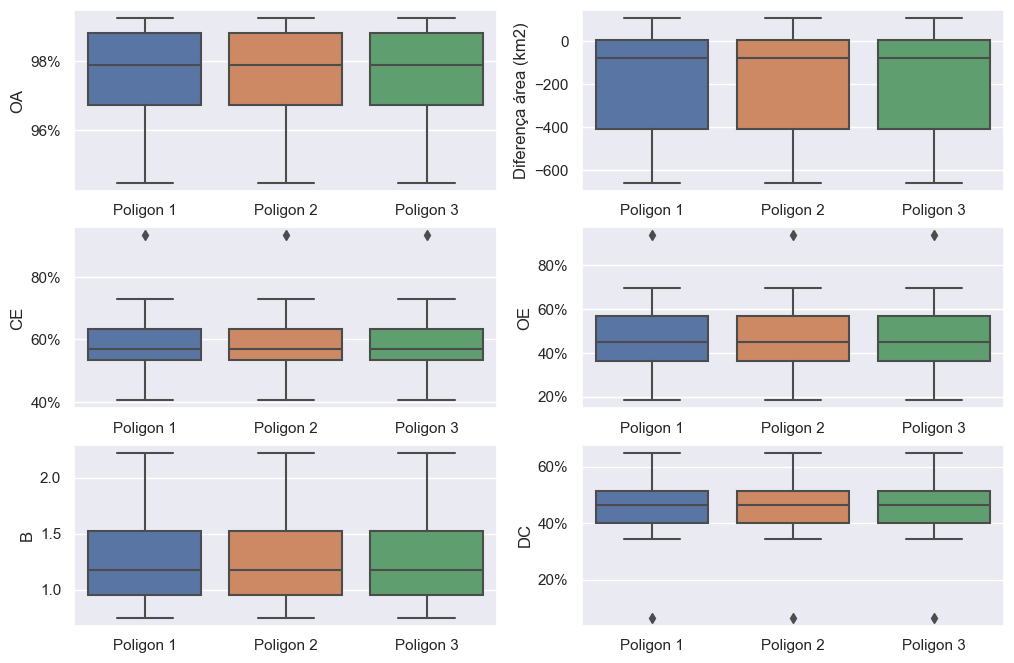

In [200]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs: list[plt.Axes] = axs.flat

files = [
    'results/validate_results_1689518843.csv',
    'results/validate_results_1689518843.csv',
    'results/validate_results_1689518843.csv'
]

names = [
    'Poligon 1',
    'Poligon 2',
    'Poligon 3',
]

def read_set(file: str, name: str):
    data_set = pd.read_csv(file)
    data_set['eval'] = name
    data_set['Diferença área (km2)'] = data_set['reference_area_km2'] - data_set['model_area_km2']
    return data_set

data_sets = pd.concat([read_set(file, name) for (file, name) in zip(files, names)], ignore_index=True)
data_sets['OA'] = data_sets['ACC']

columns = ['OA', 'Diferença área (km2)', 'CE', 'OE', 'B', 'DC']

for i, column in enumerate(columns):
    # data = [data_set[column] for data_set in data_sets]
    # labels = [names[d] for d in range(len(data_sets))]
    sns.boxplot(ax=axs[i], data=data_sets, y=column, x="eval", orient='v', dodge=False)
    if column in ['OA', 'CE', 'OE', 'DC']:
        axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    axs[i].set(xlabel=None)  # remove the axis label
    # axs[i].boxplot(data, labels=labels)


In [154]:
def validate_plot(file: str, quadrat_width: float=0.005, burned_area_calc=None):
    path, row, start, end = get_infos_from_aq30m(file)
    geometry = get_landsat_geometry(path, row)
    aqm_gdf, aqm_norm_gdf = read_file_normalized_cached(path, row, file, quadrat_width)
    explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
    explorer = SatellitesExplore(explore_df, 
                                delimited_region=geometry,
                                quadrat_width=quadrat_width, 
                                burned_area_calc=BurnedAreaCalcPercentile(expoent=2) if burned_area_calc is None else burned_area_calc,
                                min_area_percentage=min_area_percentage,
                                threshold_satellite=threshold_satellite)
    xmin, ymin, xmax, ymax = geometry.bounds

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
    fig.tight_layout()

    plot_burned_gdf(ax1, aqm_norm_gdf, legend=False)
    configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
    cx.add_basemap(ax1, crs=aqm_norm_gdf.crs.to_string())
    ax1.plot(*geometry.exterior.xy)
    ax1.set_title('AQ30m')
    ax1.legend(title = "{:.2f}Km²".format(aqm_gdf['km2'].sum()), loc='lower left')

    explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds', with_color_bar=False)
    configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
    cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())
    ax2.plot(*geometry.exterior.xy)
    ax2.set_title('AQ-FA')

    print(explorer.burned_area_calc)
    burned = explorer.get_burned_areas()
    temp = gpd.GeoDataFrame({ 'value': burned['burned_fac'], 'geometry': burned['geometry'] }, crs=burned.crs)
    fig.savefig(os.path.join(image_folder, f'validacao_{path}_{row}.pdf'), bbox_inches="tight")
    print(evaluate_gpd(aqm_norm_gdf, temp))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 8.75 max_range: 15
valinddidiid
{'TP': 1612.521808931136, 'FP': 764.2413093889543, 'FN': 725.6774474519825, 'TN': 86823.55943422792, 'ACC': 0.9834317243417817, 'CE': 0.3215471089643651, 'OE': 0.31035740237746395, 'B': 1.0164929750241323, 'DC': 0.6840019838048608, 'TPR': 0.6896425976225361, 'TNR': 0.9912745690278718, 'PPV': 0.678452891035635, 'NPV': 0.9917112076210018, 'CSI': 0.5197591298674386}


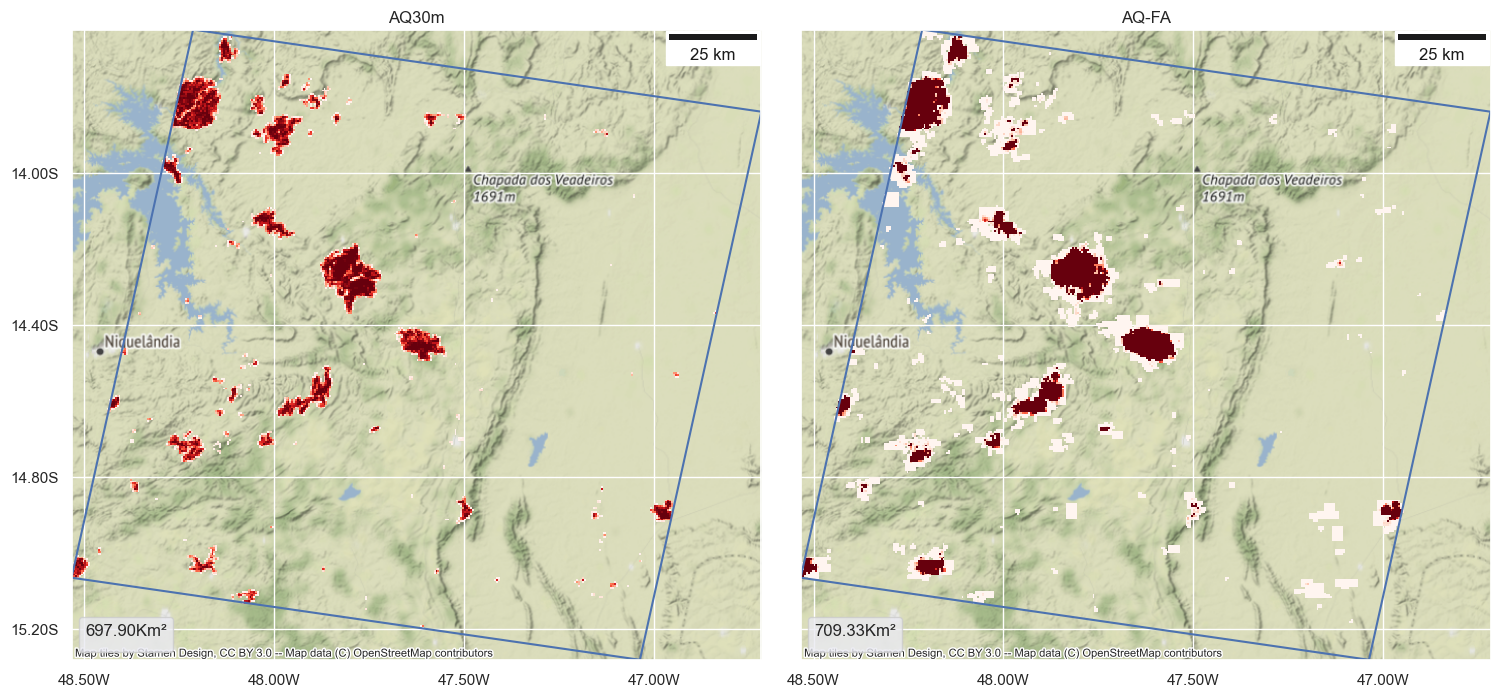

In [153]:
validate_plot(file='aq30m/LS8_AQM_221_070_20170910_0110.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 3.2906973360265264 max_range: 9.438837495794449
{'TP': 294.42016875892267, 'FP': 611.2382060684231, 'FN': 224.75186054699435, 'TN': 88707.58976462566, 'ACC': 0.9906944715308064, 'CE': 0.6749103448471386, 'OE': 0.43290440905968286, 'B': 1.7444282890935472, 'DC': 0.413270474724353, 'TPR': 0.5670955909403171, 'TNR': 0.9931566701001835, 'PPV': 0.3250896551528613, 'NPV': 0.9974727769848424, 'CSI': 0.26045426655343773}


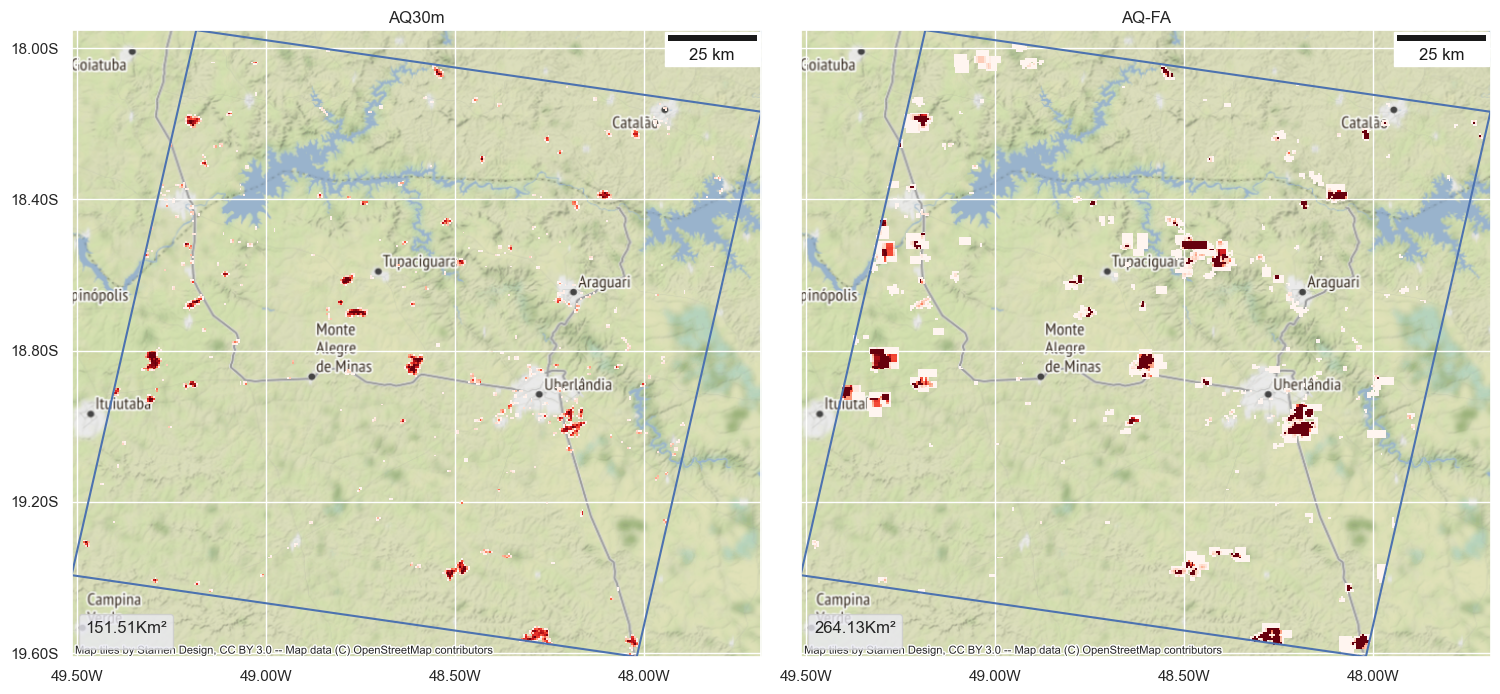

In [157]:
validate_plot(file='aq30m/LS8_AQM_221_073_20200918_0113.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 5.442141051994357 max_range: 15
{'TP': 395.3999522296828, 'FP': 322.5853884009249, 'FN': 417.35998801848217, 'TN': 88763.65467135092, 'ACC': 0.9917691478612731, 'CE': 0.4492924439342977, 'OE': 0.5135095461164672, 'B': 0.883391645030365, 'DC': 0.5166110353810021, 'TPR': 0.48649045388353285, 'TNR': 0.9963789538296312, 'PPV': 0.5507075560657024, 'NPV': 0.9953200802927327, 'CSI': 0.34826404112672593}


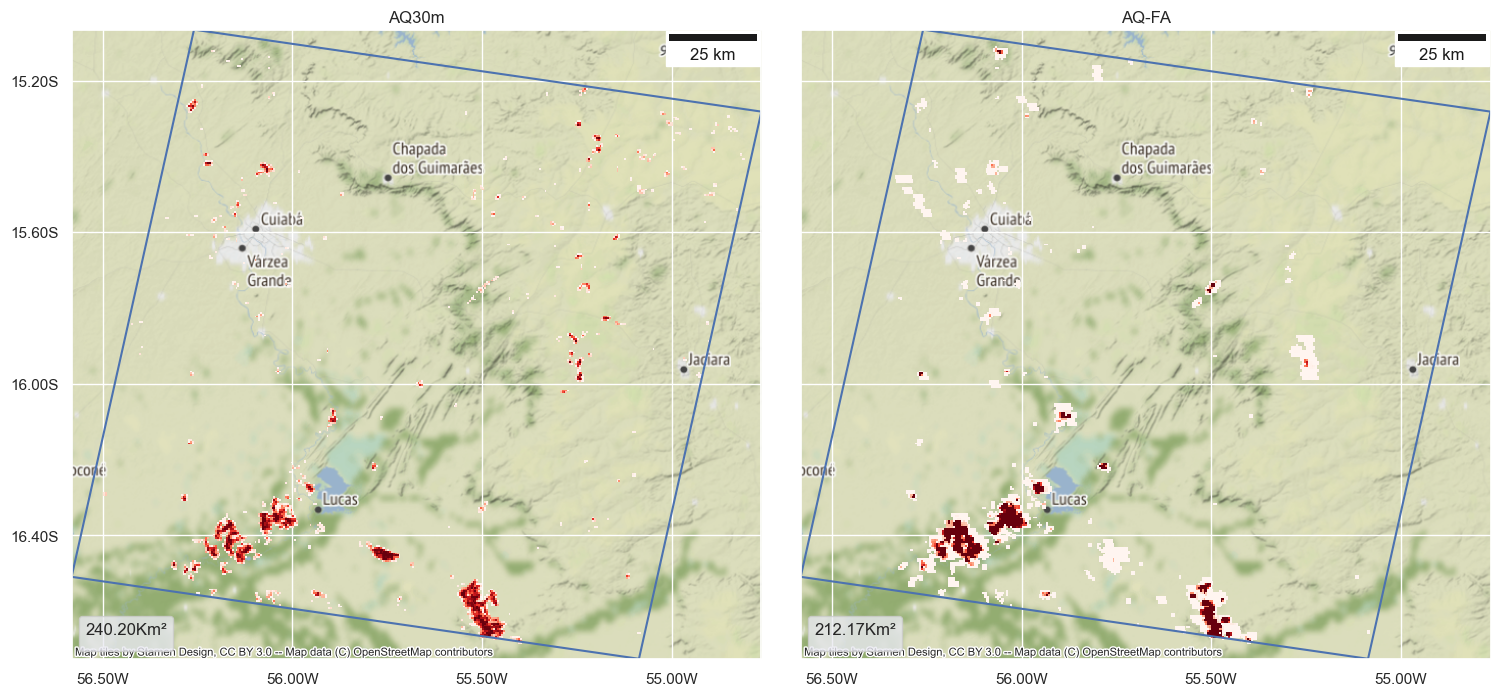

In [158]:
validate_plot(file='aq30m/LS8_AQM_226_071_20191005_0111.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 8.75 max_range: 15
{'TP': 2134.739165244317, 'FP': 690.5694712660811, 'FN': 1807.2644041034964, 'TN': 85315.42695938611, 'ACC': 0.9722302455266424, 'CE': 0.2444226667281982, 'OE': 0.4584634113871439, 'B': 0.7167189442646377, 'DC': 0.630897201224543, 'TPR': 0.541536588612856, 'TNR': 0.9919706822788468, 'PPV': 0.7555773332718018, 'NPV': 0.979256099922771, 'CSI': 0.460810686961436}


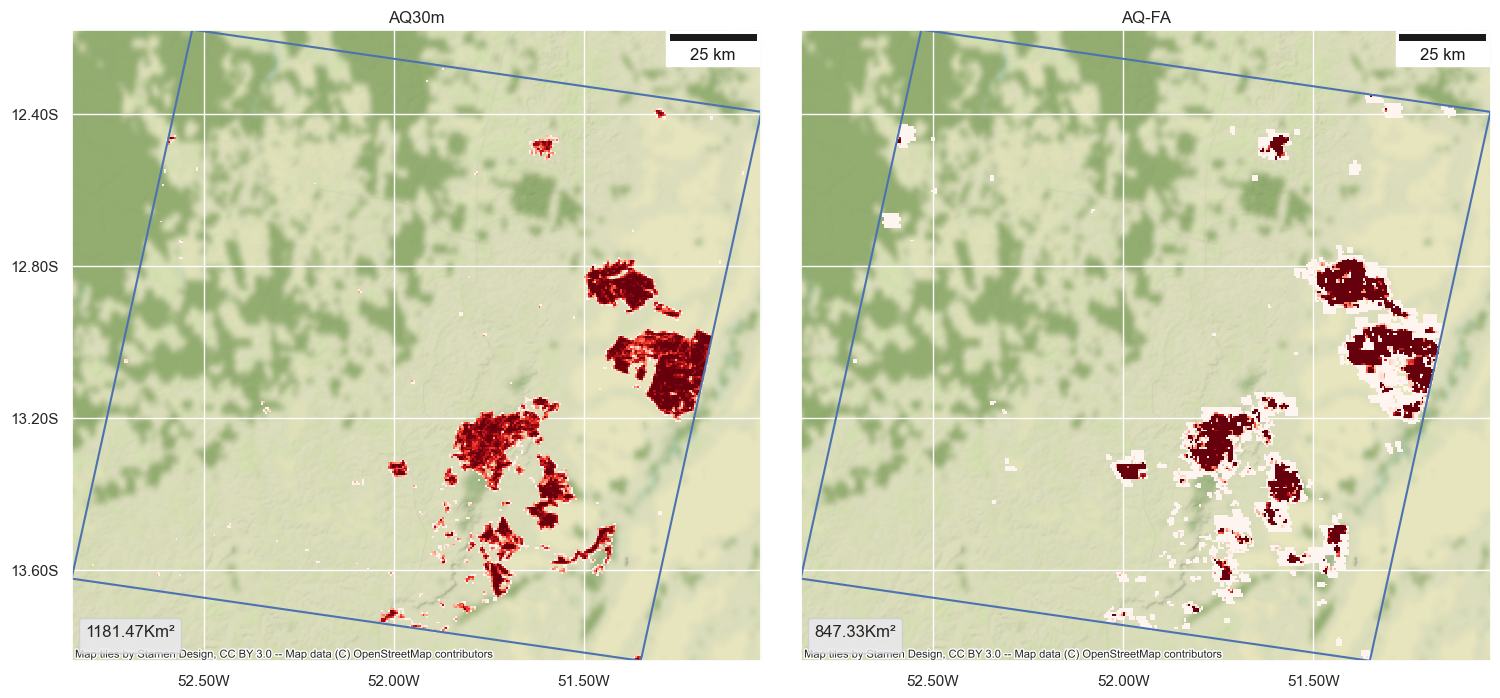

In [164]:
validate_plot(file='aq30m/LS8_AQM_224_069_20210910_0109.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


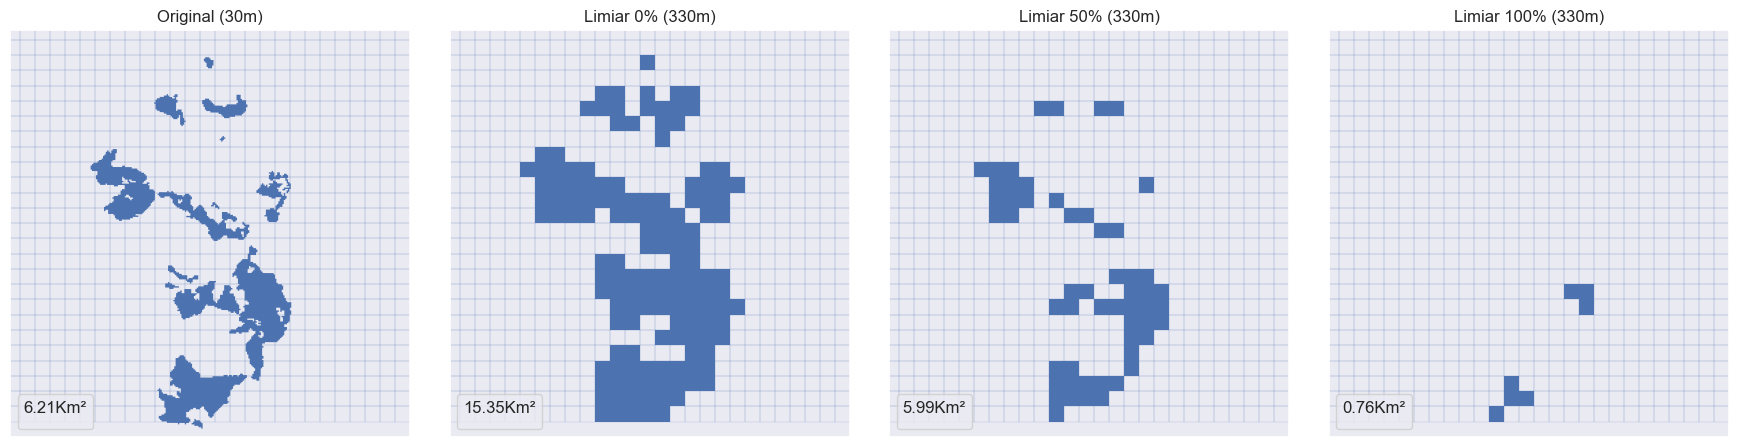

In [152]:
# cmap1 = copy.copy(plt.cm.rainbow)
quadrat_width = 0.003
linewidth = 0.1
geometry = box(-47.27, -10.77, -47.19, -10.69)
xmin, ymin, xmax, ymax = geometry.bounds
geod = Geod(ellps="WGS84")

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

threshold = [0.0, 0.5, 0.9999]

for i, t in enumerate(threshold):
    ax = axs[i+1]
    test = normalize_gdf(aqm30, geometry, quadrat_width)
    test.loc[test['value'] > t, 'value'] = 1
    test.loc[test['value'] <= t, 'value'] = 0
    plot_burned_gdf(ax, test, simple = True)
    test.boundary.plot(ax=ax, linewidth=linewidth)
    new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
    ax.set_title(f"Limiar {round(t * 100)}% ({round(new_resolution)}m)")

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'diferenca_resoluções.pdf'), bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


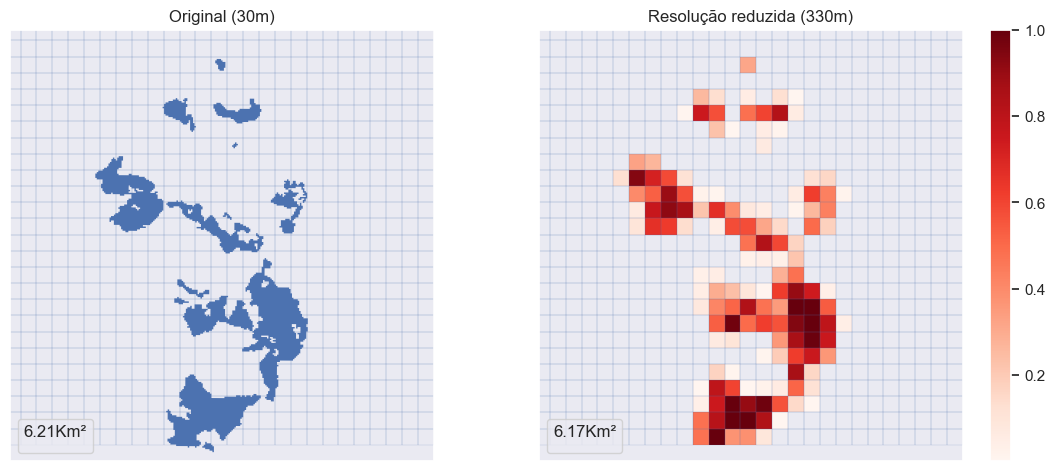

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

ax2 = axs[1]
test = normalize_gdf(aqm30, geometry, quadrat_width)
plot_burned_gdf(ax2, test)
test.boundary.plot(ax=ax2, linewidth=linewidth)
new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
ax2.set_title(f'Resolução reduzida ({round(new_resolution)}m)')

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'resolução_continua.pdf'), bbox_inches="tight")